# OD-boosting parameter analysis

We explore if ODs are aligned with directions that are boosted by the last MLP down-projection matrix.

The following is a demo of our paper. If you use this code, please cite us:

```
@misc{macocco:etal:2025,
      title={Outlier dimensions favor frequent tokens in language models}, 
      author={Iuri Macocco and Nora Graichen and Gemma Boleda and Marco Baroni},
      year={2025},
      eprint={2503.21718},
      archivePrefix={arXiv},
      primaryClass={cs.CL},
      url={https://arxiv.org/abs/2503.21718}, 
}
```

In [1]:
import torch
from transformers import AutoModelForCausalLM as MOD
import numpy as np
import torch
import json
from matplotlib import pyplot as plt
import pickle
import glob
import re
import gc

In [2]:
#!pip install --upgrade git+https://github.com/huggingface/transformers.git

In [3]:
def get_mlp_weights_and_biases(model, layer_index):
    """
    Extract the MLP weights and biases from a given layer of a Hugging Face autoregressive LLM.

    Args:
        model: The loaded Hugging Face model.
        layer_index (int): The index of the transformer block/layer.

    Returns:
        dict: A dictionary containing 'mlp_1' and 'mlp_2' weight and bias data.
    """
    mlp_data = {}

    # Handle different model structures
    if hasattr(model, "model"):  # LLaMA, Mistral, Gemma, Olmo
        transformer = model.model
    elif hasattr(model, "transformer"):  # OPT, Qwen
        transformer = model.transformer
    elif hasattr(model, "base_model"):  # Pythia, stability?
        transformer = model.base_model        
    else:
        raise ValueError("Unsupported model structure")

    # Get the layer
    if hasattr(transformer, "layers"):
        layer = transformer.layers[layer_index]
    elif hasattr(transformer, "decoder"):  # OPT
        layer = transformer.decoder.layers[layer_index]
    else:
        raise ValueError("Unsupported transformer structure")

    # Identify MLP module
    if hasattr(layer, "mlp"):
        mlp = layer.mlp  # LLaMA, Mistral, Gemma, Olmo, pythia
    elif hasattr(layer, "fc1") and hasattr(layer, "fc2"):  # OPT, Pythia
        mlp = layer
    elif hasattr(layer, "up_proj") and hasattr(layer, "down_proj"):  # LLaMA, Mistral, Gemma
        mlp = layer
    else:
        raise ValueError("Could not find MLP in the layer")

    # Extract first MLP weight and bias
    if hasattr(mlp, "fc1"):
        mlp_data["mlp_1"] = {"weight": mlp.fc1.weight.detach().cpu().numpy()}
        if hasattr(mlp.fc1, "bias") and mlp.fc1.bias is not None:
            mlp_data["mlp_1"]["bias"] = mlp.fc1.bias.detach().cpu().numpy()
    elif hasattr(mlp, "up_proj"):
        mlp_data["mlp_1"] = {"weight": mlp.up_proj.weight.detach().cpu().numpy()}
        if hasattr(mlp.up_proj, "bias") and mlp.up_proj.bias is not None:
            mlp_data["mlp_1"]["bias"] = mlp.up_proj.bias.detach().cpu().numpy()
    elif hasattr(mlp, "dense_h_to_4h"):
        mlp_data["mlp_1"] = {"weight": mlp.dense_h_to_4h.weight.detach().cpu().numpy()}

    # Extract second MLP weight and bias
    if hasattr(mlp, "fc2"):
        mlp_data["mlp_2"] = {"weight": mlp.fc2.weight.detach().cpu().numpy()}
        if hasattr(mlp.fc2, "bias") and mlp.fc2.bias is not None:
            mlp_data["mlp_2"]["bias"] = mlp.fc2.bias.detach().cpu().numpy()
    elif hasattr(mlp, "down_proj"):
        mlp_data["mlp_2"] = {"weight": mlp.down_proj.weight.detach().cpu().numpy()}
        if hasattr(mlp.down_proj, "bias") and mlp.down_proj.bias is not None:
            mlp_data["mlp_2"]["bias"] = mlp.down_proj.bias.detach().cpu().numpy()
    elif hasattr(mlp, "dense_4h_to_h"):
        mlp_data["mlp_2"] = {"weight": mlp.dense_4h_to_h.weight.detach().cpu().numpy()}
    return mlp_data


In [4]:
#hasattr(model.base_model, "layers")
#layer=model.base_model.layers[last_layer-1]

In [5]:
def get_last_layernorm_weights_and_biases(model):
    """
    Extract the weights and biases of the last LayerNorm in a Hugging Face autoregressive LLM.

    Args:
        model: The loaded Hugging Face model.

    Returns:
        dict: A dictionary containing 'weight' and 'bias' of the last LayerNorm.
    """
    ln_data = {}

    # Handle different model structures
    if hasattr(model, "model"):  # LLaMA, Mistral, Gemma, Olmo
        transformer = model.model
    elif hasattr(model, "transformer"):  # Pythia, OPT, Qwen
        transformer = model.transformer
    elif hasattr(model, "base_model"):  # Pythia
        transformer = model.base_model        
    else:
        raise ValueError("Unsupported model structure")

    # Identify the last LayerNorm
    if hasattr(transformer, "norm"):  # LLaMA, Mistral, Gemma
        ln = transformer.norm
    elif hasattr(transformer, "final_layernorm"):  # Pythia
        ln = transformer.final_layernorm 
    elif hasattr(transformer, "final_layer_norm"):  # Pythia
        ln = transformer.final_layer_norm
    elif hasattr(transformer, "decoder") and hasattr(transformer.decoder, "final_layer_norm"):  # OPT
        ln = transformer.decoder.final_layer_norm
    else:
        raise ValueError("Could not find the last LayerNorm in the model")

    # Extract LayerNorm weight and bias
    if hasattr(ln, "weight") and ln.weight is not None:
        ln_data["weight"] = ln.weight.detach().cpu().numpy()
    
    if hasattr(ln, "bias") and ln.bias is not None:
        ln_data["bias"] = ln.bias.detach().cpu().numpy()

    return ln_data

In [6]:
def compute_eigen(w,f):
    if f == 'mlp_2':
        ax = 1
    if f == 'mlp_1':
        ax = 0
    
    if f == 'weight':  # LayerNorm Weights
        W = w[f]  # Assuming shape (d,)
        return np.linalg.eigh(np.outer(W, W)) # Outer product instead of diag
        #return np.linalg.eigh(np.diag(W))  # Convert vector to diagonal matrix
    if f == 'bias':  # LayerNorm Bias
        B = w[f]  # Assuming shape (d,)
        return np.linalg.eigh(np.outer(B, B))
        #np.diag(B))  # Convert vector to diagonal matrix ?

    if f == 'f':
        return np.linalg.eig(w['mlp_1']["weight"].T@w['mlp_2']["weight"].T)
    else:
        X = np.tensordot(w[f]["weight"],
                     w[f]["weight"],
                     axes=([ax],[ax])
        )
        return np.linalg.eigh(X)  

In [7]:
def find_spikes(x,n_sigmas=5):
    x = np.abs(x-np.mean(x))
    return np.where(x>n_sigmas*np.std(x))[0]

def find_spikes1(x,n_sigmas=5):
    x = np.abs(x)
    return np.where(x>np.mean(x)+n_sigmas*np.std(x))[0]

def find_spikes2(x,n_sigmas=3): #5
    x = x-np.mean(x)
    return np.where(abs(x)>n_sigmas*np.std(x))[0]

In [8]:
def outlier_dims_quantile(X, loc = 0.5, glo = 0.99, sort=True):
    X = abs(X)
    medians = np.quantile(X,q=loc,axis=0)
    threshold = np.quantile(X,q=glo)
    idx = np.where(medians>threshold)[0]
    if sort:
        idx = idx[np.argsort(medians[idx])[::-1]]
    return {'rd': idx}

In [9]:
def od_overlap(evect, rep_od):
    spikes = [set(find_spikes1(evect[:,n])) for n in range(len(evect))]
    spikes_num = np.array([len(s) for s in spikes])
    spikes_rep = set(rep_od)
    spikes_overlap = np.array([len(spikes_rep.intersection(s)) for s in spikes])
    return spikes_overlap, spikes_num

## Initialization 

In [2]:
import yaml

def parse_args():
    parser = argparse.ArgumentParser(description="Run the full pipeline")
    parser.add_argument('--config', type=str, default='config.yaml', help='Path to configuration file')
    return parser.parse_args()

def load_config(path):
    with open(path, 'r') as file:
        return yaml.safe_load(file)

args = parse_args()
config = load_config(args.config)

In [10]:
model = config['run']['model']
model_json = config['run']['model_config']
final_path = config['data']['final']
final_path = final_path + model +"/"

llm = MOD.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",  # Automatically map layers to available devices
    trust_remote_code=True)  # For custom models

if model in ["olmo", "gemma", "llama", "mistral"]:
    last_layer=len(llm.model.layers)
elif model=="pythia" or  model=="stability":
    last_layer=len(llm.base_model.layers)
else:
    last_layer=len(llm.layers)

with open(f'{final_path}/OD.json') as f:
    out_rep = json.load(f)

2025-03-27 10:17:35.218567: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 10:17:35.233447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743067055.248057 3407090 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743067055.252632 3407090 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 10:17:35.269439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Reproduce additional eigenvector plots:)

In [19]:
w1 = get_mlp_weights_and_biases(model,last_layer-1)
print(w1['mlp_2']['weight'].shape)
evals, evect = compute_eigen(w1,'mlp_2')
print(evect.shape)

(5120, 13824)
(5120, 5120)


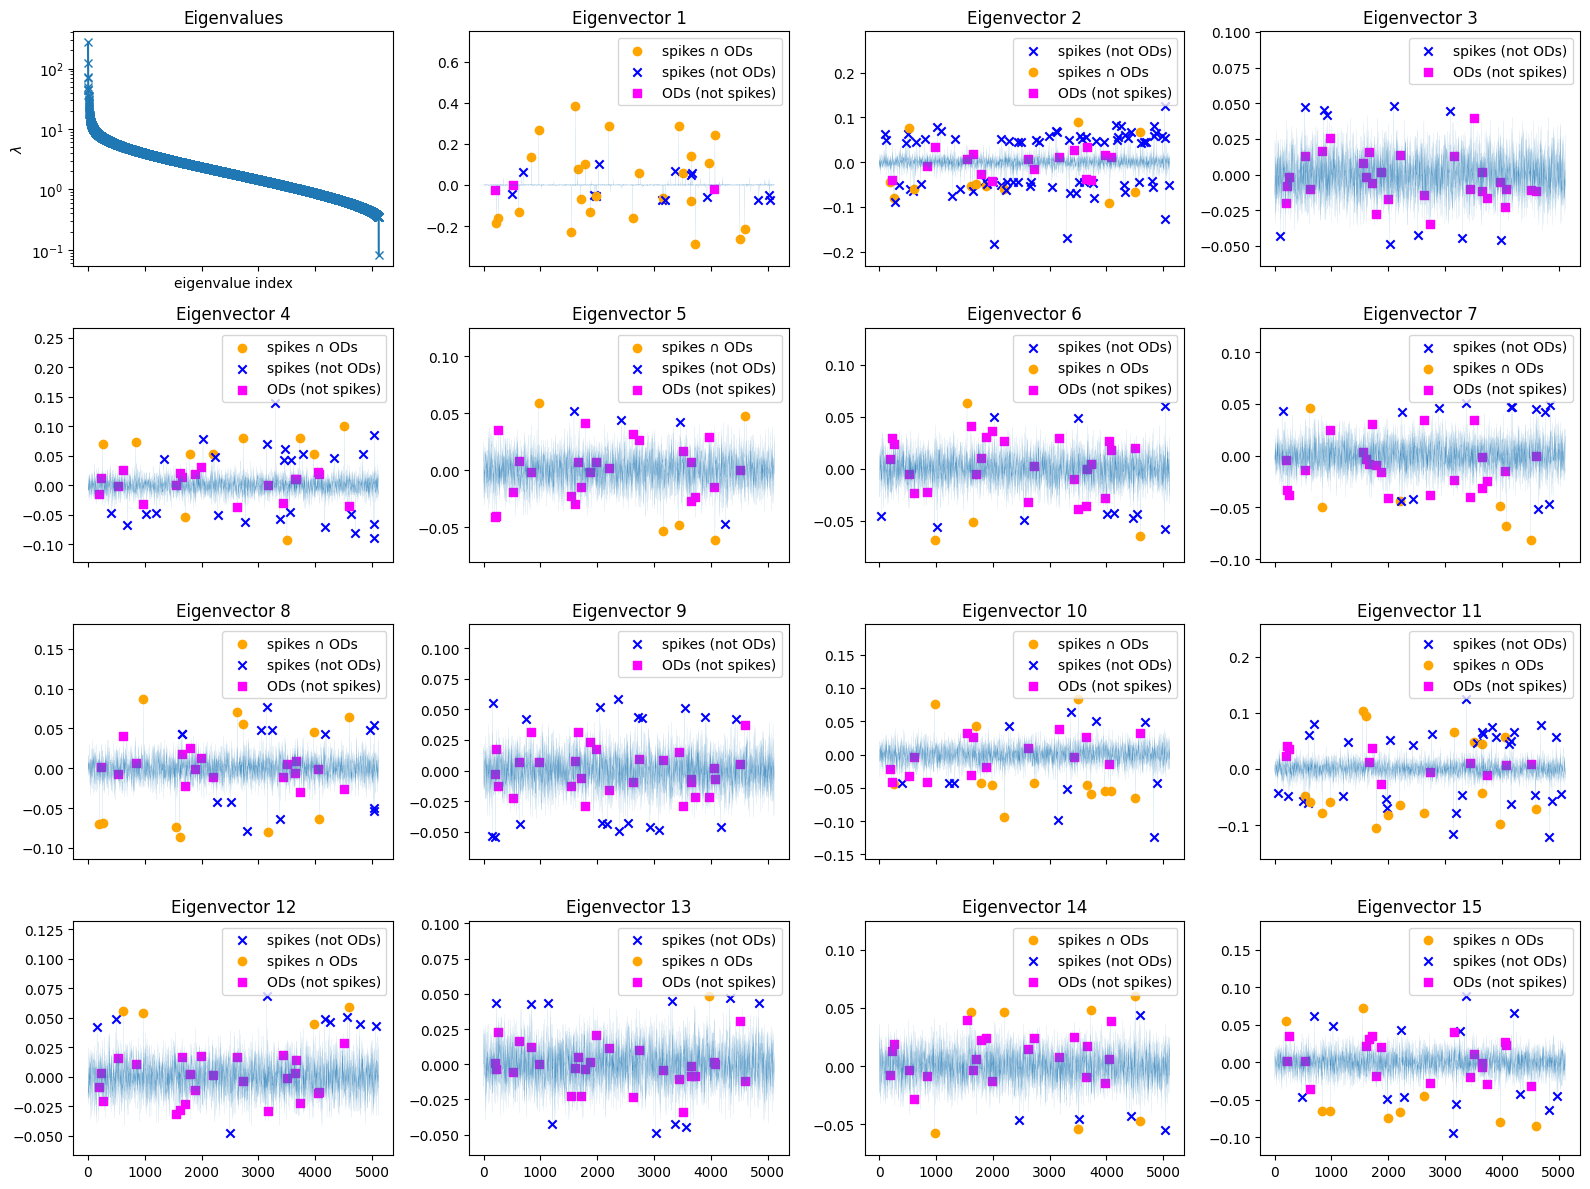

In [18]:
import matplotlib.pyplot as plt
import numpy as np

eig_ids = [-1,-2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15]
nrows = 3
ncols = 4  # Adjust to avoid excessive empty spaces

# Ensure we have enough subplots
total_plots = len(eig_ids) + 1  # +1 for eigenvalue plot
ncols = min(ncols, total_plots)  # Limit columns to the needed amount
nrows = (total_plots // ncols) + (total_plots % ncols > 0)  # Compute rows

fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=True) #sharey=True
axs = axs.flatten()  # Flatten in case of 2D indexing

# Plot eigenvalues
rev = evals.real
rev[:] = rev[::-1]
axs[0].plot(rev, 'x-')
axs[0].set_ylabel(r'$\lambda$')
axs[0].set_xlabel('eigenvalue index')
axs[0].set_yscale('log')
axs[0].set_title("Eigenvalues")

# Plot eigenvectors
f_spikes = []
for eig_id_aux, eig_id in enumerate(eig_ids):       
    
    ax = axs[eig_id_aux + 1]  # Shift by 1 since first plot is eigenvalues
    ax.plot(evect[:, eig_id],linewidth=0.05) # color='blue
    
    f_spikes.append(find_spikes2(evect[:, eig_id]))
    ax.set_title(f'Eigenvector {str(eig_id).strip("-")}')
    #ax.set_ylim(-0.25, 0.45)

    ymin, ymax = ax.get_ylim()

    # Compute the adjustment
    yrange = ymax - ymin
    new_ylim = (ymin - 0.1 * yrange, ymax + 0.45 * yrange)

    # Set the new y-limits
    ax.set_ylim(new_ylim)

    ods = set(out_rep[str(last_layer)])

    for spike in f_spikes[eig_id_aux]:
        value = evect[spike, eig_id]
        color, marker, label = ('orange','o', "spikes ∩ ODs") if spike in ods else ('blue','x', "spikes (not ODs)")
        # Check if value is in ods
        ax.scatter(spike, value, color=color, marker=marker, label=label)
    
    for spike in ods:
        value = evect[spike, eig_id]
        if spike not in f_spikes[eig_id_aux]:
            color, marker = ('fuchsia', 's')
            ax.scatter(spike, value, color=color, marker=marker, label="ODs (not spikes)")
    
    # Ensure the legend only displays unique labels
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
    ax.legend(unique_labels.values(), unique_labels.keys(), loc="upper right")
        
    #ax.set_xlabel('dimension')
    row, col = divmod(eig_id, 4)  # Get row and column index in 3x3 grid
    if row == len(axs) - 1:
        ax.set_xlabel("dimension")

# Hide unused subplots if any
for i in range(total_plots, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.savefig(final_path+'_MLP2_weights_Eigenv_sigma3.svg', bbox_inches='tight')
plt.show()

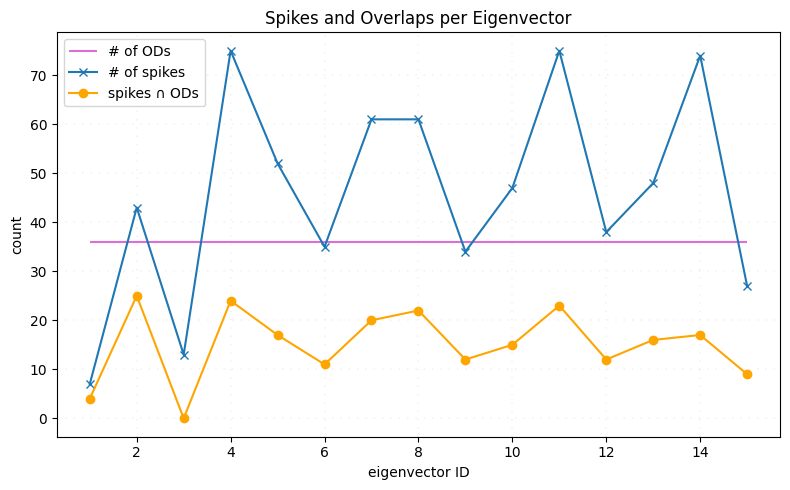

In [69]:
import matplotlib.pyplot as plt
import numpy as np

eig_ids = [-1,-2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15]
num_spikes = []
num_overlaps = []
eig_ids.reverse()

for eig_id in eig_ids:
    f_spikes = find_spikes2(evect[:, eig_id])  # Detect spikes
    ods = set(out_rep[str(last_layer)])  # Set of outlier dimensions
    overlaps = [spike for spike in f_spikes if spike in ods]  # Count overlaps

    num_spikes.append(len(f_spikes))  # Total spikes count
    num_overlaps.append(len(overlaps))  # Overlap count

# Create summary plot
fig, ax = plt.subplots(figsize=(8, 5))

plt.hlines(len(ods), [abs(i) for i in eig_ids][0], [abs(i) for i in eig_ids][-1], color="orchid", label='# of ODs')

ax.plot([abs(i) for i in eig_ids], num_spikes, marker="x", label='# of spikes')
ax.plot([abs(i) for i in eig_ids], num_overlaps, color="orange", marker="o", label='spikes ∩ ODs')

plt.title("Overlap of Spikes with ODs vs. Number of Eigenvectors")
plt.legend()

ax.set_xlabel('eigenvector ID')
ax.set_ylabel('count')
ax.set_title('Spikes and Overlaps per Eigenvector') #Summary of 
ax.legend()
plt.grid(True, linestyle =(0, (5, 25)), linewidth = 0.2)
plt.tight_layout()
plt.savefig(final_path+'_MLP2_SummaryEigen_sigma3.svg', bbox_inches='tight')
plt.show()
plt.show()

###  non-negligible overlap of spikes and ODs:

In [18]:
import random
import numpy as np
import sys

def Overlap_test(dim, odc, sc, oo, ic):
    dimensionality = int(dim)
    od_count = int(odc)
    spike_count = int(sc)
    observed_overlap = int(oo)
    iteration_count =  int(ic)
    
    od_vector = np.array([1] * od_count + [0] * (dimensionality - od_count))
    spike_vector = np.array([1] * spike_count + [0] * (dimensionality - spike_count))
    
    same_or_larger_overlap_count = 0
    
    for i in range(iteration_count):
        random.shuffle(od_vector)
        random.shuffle(spike_vector)
        overlap = np.dot(od_vector,spike_vector)
        if overlap >= observed_overlap:
            same_or_larger_overlap_count+=1
    
    return same_or_larger_overlap_count/(iteration_count+0.0)


In [19]:
w1 = get_mlp_weights_and_biases(model,last_layer-1)
print(w1['mlp_2']['weight'].shape)
evals, evect = compute_eigen(w1,'mlp_2')
print(evect.shape)

(5120, 20480)
(5120, 5120)


In [20]:
eig_ids = [-1,-2, -3, -4,] 
#eig_ids = range(7,25)

f_spikes =[]
num_spikes, num_overlaps =[],[]

for eig_id_aux, eig_id in enumerate(eig_ids):
    
    f_spikes = find_spikes2(evect[:, eig_id])  # Detect spikes
    ods = set(out_rep[str(last_layer)])  # Set of outlier dimensions
    overlaps = [spike for spike in f_spikes if spike in ods]  # Count overlaps

    print(len(f_spikes), len(ods), len(overlaps))
    
    num_spikes.append(len(f_spikes))  # Total spikes count
    num_overlaps.append(len(overlaps))  # Overlap count

    print(Overlap_test(len(evect[:, eig_id]), num_overlaps[-1], num_spikes[-1], len(overlaps), 1000))


7 36 4
0.0
43 36 25
0.0
13 36 0
1.0
75 36 24
0.0


In [21]:
num_spikes

[7, 43, 13, 75]

In [22]:
num_overlaps

[4, 25, 0, 24]

In [23]:
w2 = get_last_layernorm_weights_and_biases(model)
ln_w= w2['weight']

In [24]:
    f_spikes= (find_spikes2(ln_w))
    ods = set(out_rep[str(last_layer)])  # Set of outlier dimensions
    overlaps = [spike for spike in f_spikes if spike in ods]  # Count overlaps

    print(len(f_spikes), len(ods), len(overlaps))
    
    num_spikes.append(len(f_spikes))  # Total spikes count
    num_overlaps.append(len(overlaps))  # Overlap count

    print(Overlap_test(len(ln_w), num_overlaps[-1], num_spikes[-1], len(overlaps), 1000))

52 36 16
0.0


In [25]:
    ln_w= w2['bias']
    f_spikes= (find_spikes2(ln_w))
    ods = set(out_rep[str(last_layer)])  # Set of outlier dimensions
    overlaps = [spike for spike in f_spikes if spike in ods]  # Count overlaps

    print(len(f_spikes), len(ods), len(overlaps))
    
    num_spikes.append(len(f_spikes))  # Total spikes count
    num_overlaps.append(len(overlaps))  # Overlap count

    print(Overlap_test(len(ln_w), num_overlaps[-1], num_spikes[-1], len(overlaps), 1000))

39 36 20
0.0


### Reproduce Plots
depending whether there are LN biases

In [18]:
def plot_weights(ax):
    w2 = get_last_layernorm_weights_and_biases(model)
    ln_w= w2['weight']
    
    eig_ids = [-1]
    nrows = 1
    ncols = 2 
    
    f_spikes = []

    
    ax.plot(ln_w, linewidth=0.05)
    f_spikes.append(find_spikes2(ln_w))
    ax.set_title(f'Eigenvector {str(eig_ids).strip("-")}')
    ods = set(out_rep[str(last_layer)])
    for eig_id_aux,eig_id in enumerate(eig_ids):
        for spike in ods:
            value = ln_w[spike]
            if spike not in f_spikes[eig_id_aux]:
                color, marker = ('fuchsia', 's')
                ax.scatter(spike, value, color=color, marker=marker, label="ODs (not spikes)")
            
        for spike in f_spikes[eig_id_aux]:
            value = ln_w[spike]
            color, marker, label = ('orange','o', "spikes ∩ ODs") if spike in ods else ('blue','x', "spikes (not ODs)")
            ax.scatter(spike, value, color=color, marker=marker, label=label)
        
    ymin, ymax = ax.get_ylim()

    # Compute the adjustment
    yrange = ymax - ymin
    new_ylim = (ymin - 0.05 * yrange, ymax + 0.05 * yrange)

    # Set the new y-limits
    ax.set_ylim(new_ylim)
    
    # Ensure the legend only displays unique labels
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
    #ax.legend(unique_labels.values(), unique_labels.keys(),loc="lower left") # "upper right"
        
    ax.set_xlabel('dimension')
    #ax.set_ylabel('Count')
    ax.set_title('Spikes & OD Overlap - LayerNorm Weights', fontsize=10) #fontweight='bold'
    #plt.tight_layout()
    return ax

In [19]:
def plot_bias(ax):
    w2 = get_last_layernorm_weights_and_biases(model)
    ln_w= w2['bias'] #bias
    
    eig_ids = [-1]
    nrows = 1
    ncols = 2 
    
    f_spikes = []
    
    ax.plot(ln_w, linewidth=0.05)
    f_spikes.append(find_spikes2(ln_w))
    ax.set_title(f'Eigenvector {str(eig_ids).strip("-")}')
    ods = set(out_rep[str(last_layer)])
    for eig_id_aux,eig_id in enumerate(eig_ids):
        for spike in ods:
            value = ln_w[spike]
            if spike not in f_spikes[eig_id_aux]:
                color, marker = ('fuchsia', 's')
                ax.scatter(spike, value, color=color, marker=marker, label="ODs (not spikes)")
            
        for spike in f_spikes[eig_id_aux]:
            value = ln_w[spike]
            color, marker, label = ('orange','o', "spikes ∩ ODs") if spike in ods else ('blue','x', "spikes (not ODs)")
            ax.scatter(spike, value, color=color, marker=marker, label=label)
        
    #ax.set_ylim(ln_w.min()- (*ln_w.min()/100),ln_w.max()+(10*ln_w.max()/100))
    #ax.set_ylim(ln_w.min(),ln_w.max())
    ymin, ymax = ax.get_ylim()

    # Compute the adjustment
    yrange = ymax - ymin
    new_ylim = (ymin - 0.05 * yrange, ymax + 0.01 * yrange)

    # Set the new y-limits
    ax.set_ylim(new_ylim)
    
    # Ensure the legend only displays unique labels
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
    #ax.legend(unique_labels.values(), unique_labels.keys(),loc="lower left") # "upper right"
        
    ax.set_xlabel('dimension')
    #ax.set_ylabel('Count')
    ax.set_title('Spikes & OD Overlap - LayerNorm Bias', fontsize=10) #fontweight='bold'
    #plt.tight_layout()
    return ax

In [24]:
def plot_Eigen(ax, evals, eig_id_aux, eig_id):  
    # Plot eigenvalues
    #rev = evals.real
    #rev[:] = rev[::-1]
    f_spikes = []
    
    ax.plot(evect[:, eig_id],linewidth=0.05) # color='blue
        
    f_spikes.append(find_spikes2(evect[:, eig_id]))
    ax.set_title(f'Eigenvector {str(eig_id).strip("-")}', fontsize=10) # fontweight='bold'
        
    ods = set(out_rep[str(last_layer)])
    
    for spike in f_spikes[0]: #eig_id_aux
        value = evect[spike, eig_id]
        color, marker, label = ('orange','o', "spikes ∩ ODs") if spike in ods else ('blue','x', "spikes (not ODs)")
        # Check if value is in ods
        ax.scatter(spike, value, color=color, marker=marker, label=label)
        
    for spike in ods:
        value = evect[spike, eig_id]
        if spike not in f_spikes[0]: #eig_id_aux
            color, marker = ('fuchsia', 's')
            ax.scatter(spike, value, color=color, marker=marker, label="ODs (not spikes)")
        
    # Ensure the legend only displays unique labels
    ax.plot(np.NaN, np.NaN, 'o', color='orange', label='spikes ∩ ODs')
    ax.plot(np.NaN, np.NaN, 'x', color='blue', label='spikes (not ODs)')
    ax.plot(np.NaN, np.NaN, 's', color='fuchsia', label='ODs (not spikes)')
    handles, labels = ax.get_legend_handles_labels()
    order = [0,2,1]
    #plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
    v, k = list(unique_labels.values()), list(unique_labels.keys())
    k, v = zip(*sorted(zip(k, v), key=lambda t: t[0]))
    #ax.legend(v, k, loc="upper left")
    
    #eigenvalues = np.array([3, 2, 1])  # Replace with actual eigenvalues
    lamda = evals[eig_id]  # evals.real[]
    f = np.sum(evals.real)
    fraction = lamda/f
    
    text_str = r"$\hat{\lambda}_{%s} = {%.4f}$" % (str(eig_id).strip("-"), fraction) # lamda = %.2f , fraction)
        
    if eig_id: #% 2 == 0
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, #0.95
        #ax.text(0.95, 0.95, text_str, transform=ax.transAxes, fontsize=10, #0.95
            verticalalignment='top', horizontalalignment='left', #right
            bbox=dict(facecolor='white', alpha=0.6))
        
    else:
        ax.text(0.95, 0.05, text_str, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.6))
    
    #ax.set_xlabel('dimension')
    #row, col = divmod(eig_id, 2)  # Get row and column index in 3x3 grid
    if eig_id < -2:
        ax.set_xlabel("dimension")

    ymin, ymax = ax.get_ylim()
    # Compute the adjustment
    yrange = ymax - ymin
    #new_ylim = (ymin - 0.01 * yrange, ymax + 0.03 * yrange)
    new_ylim = (ymin - 0.05 * yrange, ymax + 0.19 * yrange)
    # Set the new y-limits
    ax.set_ylim(new_ylim)
    
    ax.set_box_aspect(0.6)
    return ax, (k,v)


In [21]:
w1 = get_mlp_weights_and_biases(model,last_layer-1)
print(w1['mlp_2']['weight'].shape)
evals, evect = compute_eigen(w1,'mlp_2')
print(evect.shape)

(4096, 14336)
(4096, 4096)


KeyError: 'bias'

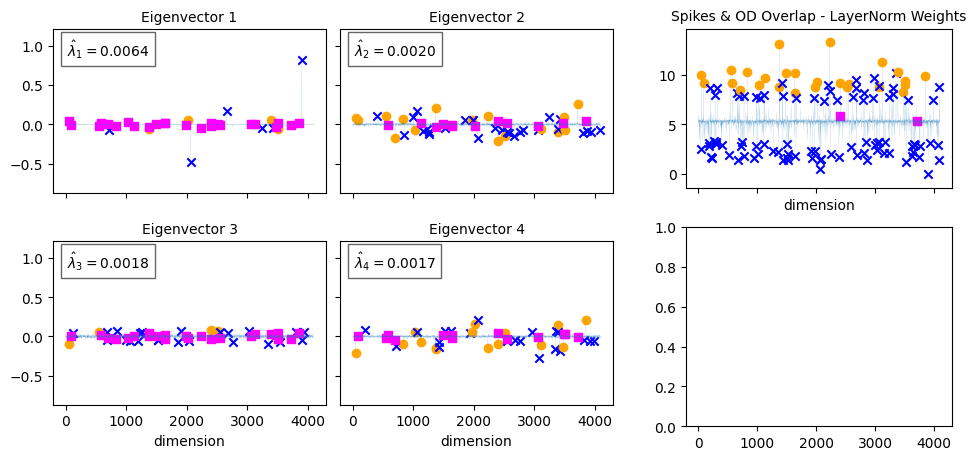

In [21]:
import matplotlib.pyplot as plt
import numpy as np

'''def example_plot(ax, fontsize=12, hide_labels=True):
    pc = ax.pcolormesh(np.random.randn(30, 30), vmin=-2.5, vmax=2.5)
    if not hide_labels:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)
    return pc'''

eig_ids = [-1, -2, -3, -4]

# Plot eigenvalues
#rev = evals.real
#rev[:] = rev[::-1]

# Create figure and subfigures (left side with 2x2, right side with 3x1)
fig = plt.figure(layout='constrained', figsize=(9.5,4.5))
subfigs = fig.subfigures(1, 2, wspace=0.07,  width_ratios=[2, 1])

# Left side: 2x2 subplots
axsLeft = subfigs[0].subplots(2, 2, sharey=True, sharex=True)  # Change from 1x2 to 2x2 grid
#axsLeft = subfigs[0].subplots(2, 2, figsize=(8, 6), constrained_layout=True, sharex=True, sharey=True)

for ax, (eig_id_aux, eig_id) in zip(axsLeft.flat, enumerate(eig_ids)):  # Iterate over all subplots
    pc, (k,v) = plot_Eigen(ax, evals, eig_id_aux, eig_id)
    
#subfigs[0].suptitle('Left plots (2x2)', fontsize='x-large')
#subfigs[0].colorbar(pc, shrink=0.6, ax=axsLeft, location='bottom')
#, (k,v)

# Right side: 3x1 subplots (unchanged)
axsRight = subfigs[1].subplots(2, 1, sharex=True)
for nn, ax in enumerate(axsRight):
    if nn ==1:
        pc = plot_bias(ax)
        ax.set_box_aspect(0.6)
    else:
        pc = plot_weights(ax)
        ax.set_box_aspect(0.6)

    #if nn == 1:
        #ax.set_xlabel('xlabel')
    #if nn == 0:
        #ax.set_ylabel('ylabel')

#fig.suptitle('Figure suptitle', fontsize='xx-large')
#fig.subplots_adjust(bottom=0.01, wspace=0.03)
#subfigs[1].set_facecolor('0.95')

fig.legend(handles = v, labels=k,loc='upper center', 
             bbox_to_anchor=(0.5, -0.0),fancybox=False, shadow=False, ncol=3)


#plt.tight_layout()
plt.savefig(final_path+'_6pack_final.svg', bbox_inches='tight')
plt.show()


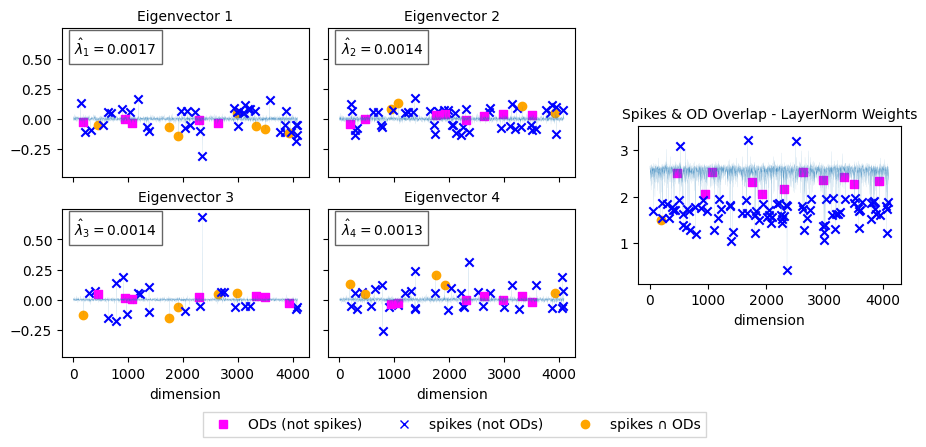

In [25]:
import matplotlib.pyplot as plt
import numpy as np

eig_ids = [-1, -2, -3, -4]

# Plot eigenvalues
#rev = evals.real
#rev[:] = rev[::-1]

# Create figure and subfigures (left side with 2x2, right side with 3x1)
fig = plt.figure(layout='constrained', figsize=(9,4))
subfigs = fig.subfigures(1, 2, wspace=0.07,  width_ratios=[2, 1])#height_ratios=[1,2]

# Left side: 2x2 subplots
axsLeft = subfigs[0].subplots(2, 2, sharey=True, sharex=True)  # Change from 1x2 to 2x2 grid
#axsLeft = subfigs[0].subplots(2, 2, figsize=(8, 6), constrained_layout=True, sharex=True, sharey=True)

for ax, (eig_id_aux, eig_id) in zip(axsLeft.flat, enumerate(eig_ids)):  # Iterate over all subplots
    pc, (k,v) = plot_Eigen(ax, evals, eig_id_aux, eig_id)
    
#subfigs[0].suptitle('Left plots (2x2)', fontsize='x-large')
#subfigs[0].colorbar(pc, shrink=0.6, ax=axsLeft, location='bottom')
#, (k,v)

# Right side: 3x1 subplots (unchanged)
axsRight = subfigs[1].subplots(1, 1, sharex=True, )
#for ax in axsRight:
pc = plot_weights(axsRight)

axsRight.set_box_aspect(0.6)
#axsRight.set_aspect(0.5)
    
    
#fig.suptitle('Figure suptitle', fontsize='xx-large')
#fig.subplots_adjust(bottom=0.01, wspace=0.03)
fig.legend(handles = v, labels=k,loc='upper center', 
             bbox_to_anchor=(0.5, -0.0),fancybox=False, shadow=False, ncol=3)

#plt.tight_layout()
plt.savefig(final_path+'_5pack_final.svg', bbox_inches='tight')
plt.show()

/tmp/ipykernel_1543053/1854958625.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


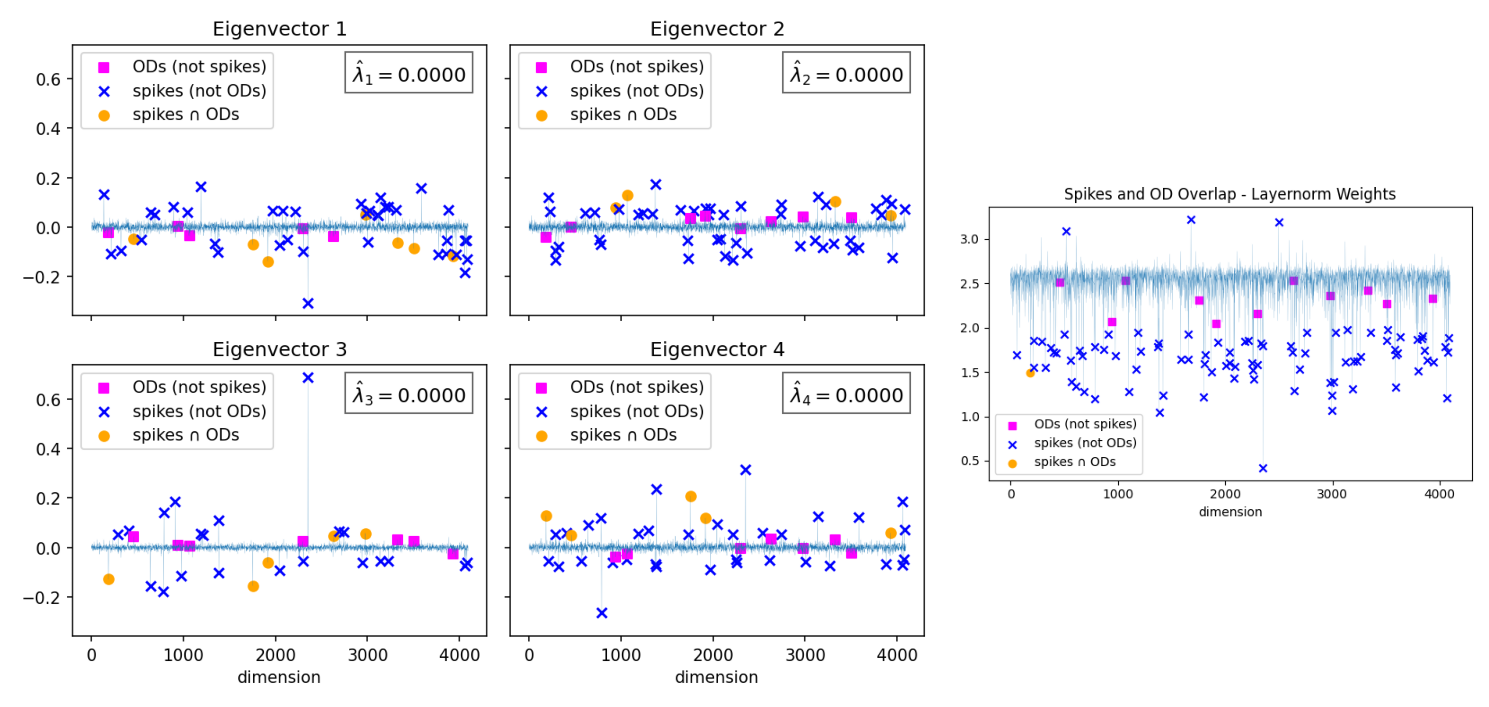

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec

# Example Data for the Top Plot
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
# Paths to Images (Replace with actual image paths)
image_path1 = plot_mlp_dir+'MLP2_weights_4numlamdaEigenv_non.png'  # Large Image (spanning the first column) #MLP2_weights_4Eigenv_non.png
#image_path2 = plot_mlp_dir+'Layernorm_weights.png'  # Smaller Image (in the right column, top row)
image_path3 = plot_mlp_dir+'Layernorm_weights.png'  # Smaller Image (in the right column, bottom row)

# Create figure with GridSpec and constrained_layout=True
fig = plt.figure(figsize=(15, 8), constrained_layout=True)  # Adjust the size
gs = GridSpec(2, 2, width_ratios=[1.75, 1])  # First column is twice as wide

# Top Row - First column: Larger Image
ax1 = fig.add_subplot(gs[:, 0])  # Spans first row, first column
img1 = mpimg.imread(image_path1)
ax1.imshow(img1)
ax1.axis("off")  # Hide axes
#ax1.set_title("Large Image (Spanning Column 1)")

# Top Row - Second column: Smaller Image

# Bottom Row - Second column: Smaller Image
ax3 = fig.add_subplot(gs[:, 1])  # Second row, second column
img3 = mpimg.imread(image_path3)
ax3.imshow(img3)
ax3.axis("off")  # Hide axes



# Show the final layout
# Adjust layout
#fig.subplots_adjust(hspace=0.001)
plt.tight_layout()
#plt.subplots_adjust(hspace=0.001, wspace=0.002)  # Reduce vertical & horizontal gaps
#plt.subplots_adjust(hspace=0.05, wspace=0.05)  # Reduce vertical and horizontal space
plt.savefig(plot_mlp_dir+'MLP2_Weight_6pack.pdf',bbox_inches='tight')#, dpi=150)
plt.show()

#ax3.set_title("Bottom Right Image")

#  # Lower values bring them closer


### linear combination MLP2

In [25]:
w1 = get_mlp_weights_and_biases(model,last_layer-1)

#print(w1['mlp_2']['weight'].shape)
# Compute eigenvalues and eigenvectors

#modeln="stability"
if modeln=="stability":
    evals, evect = compute_eigen(w1, 'mlp_1')
else:
    evals, evect = compute_eigen(w1, 'mlp_2')

N = 5  # Number of top eigenvectors to use

# Sort eigenvalues in descending order and get corresponding indices
top_indices = np.argsort(np.abs(evals))[::-1][:N]  

# Compute the linear combination
v_combined = np.sum(evals[top_indices] * evect[:, top_indices], axis=1)

print("Combined Vector Shape:", v_combined.shape)
print("First 10 elements of v_combined:", v_combined[:10])

Combined Vector Shape: (4096,)
First 10 elements of v_combined: [-0.37231925  0.25494197  0.24252178 -0.23469299  0.22136621  0.3698406
  0.45396298 -0.17738007  0.13888705 -0.20116402]


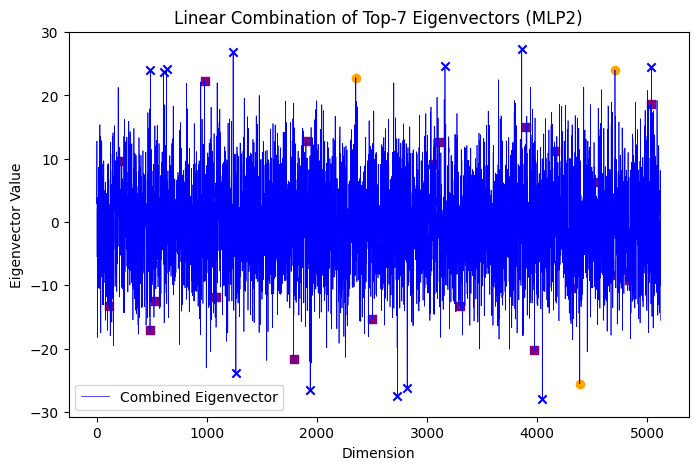

In [45]:
# Sort eigenvalues in descending order and get corresponding indices
N=7
#top_indices = np.argsort(np.abs(evals))[::-1][:N]
top_indices = np.argsort(evals.real)[::-1][:N]  

v_combined = np.sum(evals[top_indices] * evect[:, top_indices], axis=1)

# Find spikes in the combined vector
f_spikes = find_spikes2(v_combined)  # Use your spike detection function

# Get outlier dimensions (ODs) from `out_rep`
ods = set(out_rep[str(last_layer)])  # Convert to set for fast lookup

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(v_combined, linewidth=0.5, label="Combined Eigenvector", color='blue')
    

for spike in ods:
    value = v_combined[spike]
    if spike not in f_spikes:
        color, marker = ('purple', 's')
        ax.scatter(spike, value, color=color, marker=marker)
    else:
        continue
# Mark spikes
for spike in f_spikes:
    value = v_combined[spike]
    color, marker = ('orange', 'o') if spike in ods else ('blue', 'x')
    plt.scatter(spike, value, color=color, marker=marker)

plt.xlabel("Dimension")
plt.ylabel("Eigenvector Value")
plt.title(f"Linear Combination of Top-{N} Eigenvectors (MLP2)")
plt.legend()
plt.show()


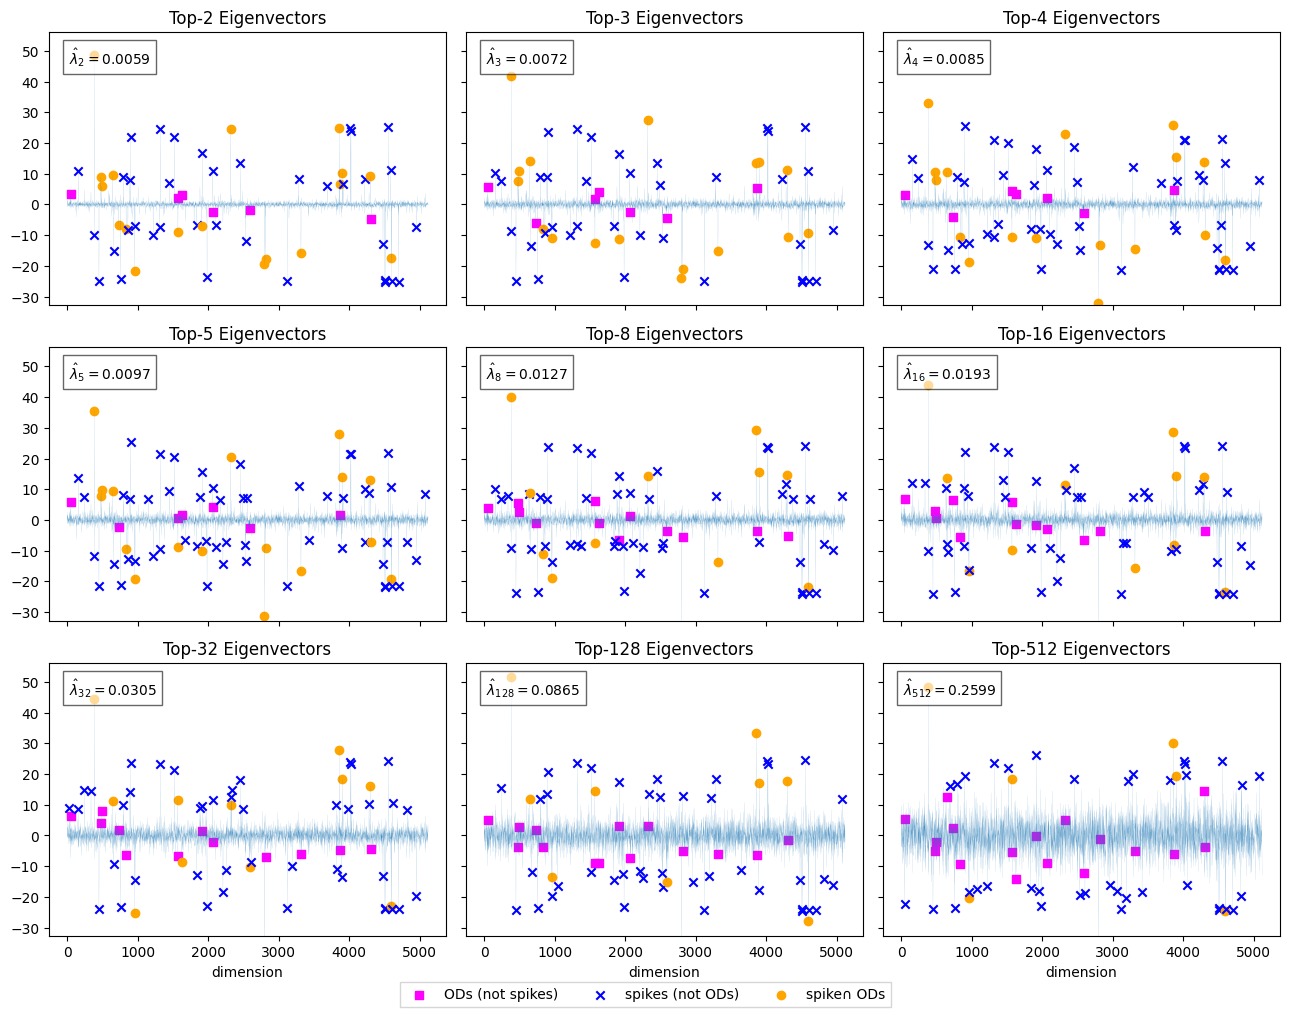

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Compute eigenvalues and eigenvectors
evals, evect = compute_eigen(w1, 'mlp_2')

# Define N values e.g., increasing by a power of 2
N_values = [2, 3, 4, 5, 8, 16, 32, 128, 512]  # Up to 9 values

var_values=[0.05,0.1, 0.2, 0.4,0.6,0.8]


# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(13, 10), sharex=True, sharey=True)

# Get outlier dimensions (ODs)
ods = set(out_rep[str(last_layer)])

sorted_evals = np.sort(np.abs(evals))[::-1]  # Sort eigenvalues in descending order
cumulative_variance = np.cumsum(sorted_evals) / np.sum(sorted_evals)  # Compute CFV

# Plot cumulative fraction of variance
#plt.figure(figsize=(7, 5))
#plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Mark specific N values
#for N in N_values:
    #if N < len(cumulative_variance):  # Ensure N is within bounds
        #plt.scatter(N, cumulative_variance[N - 1], color='red', label=f"N={N}" if N == N_values[0] else "")
    
for idx, N in enumerate(N_values):
    row, col = divmod(idx, 3)  # Get row and column index in 3x3 grid
    ax = axes[row, col]  # Select the subplot

    # Label x-axis only for the bottom row
    if row == len(axes) - 1:
        ax.set_xlabel("dimension")
        
    # Label y-axis only for the first column (leftmost plots)
    #if col == 0:  
        #ax.set_ylabel(f"Noise row: {row + 1}")
        
    # Sort and get the top-N eigenvectors
    top_indices = np.argsort(np.abs(evals))[::-1][:N]
    
    # Compute the linear combination
    v_combined = np.sum(evals[top_indices] * evect[:, top_indices], axis=1)
    
    # Find spikes
    f_spikes = find_spikes2(v_combined)
    
    # Plot in the corresponding subplot
    ax.plot(v_combined, linewidth=0.05) #color='blue' #label=f"linear combination, scaled by eigenvalue λ{N}"

    
    for spike in ods:
        value = v_combined[spike]
        if spike not in f_spikes:
            color, marker = ('fuchsia', 's')
            ax.scatter(spike, value, color=color, marker=marker, label="ODs (not spikes)")
    
    # Iterate over spikes and ODs and plot
    for spike in f_spikes:
        value = v_combined[spike]
        if spike in ods:
            color, marker, label = ('orange', 'o', "spike∩ ODs")
        else:
            color, marker, label = ('blue', 'x', "spikes (not ODs)")
        ax.scatter(spike, value, color=color, marker=marker, label=label)
    
    # Ensure the legend only displays unique labels
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
    #ax.legend(unique_labels.values(), unique_labels.keys(), loc= "upper left")
    
    # Formatting
    #ax.set_ylim(-0.45, 0.7)
    #for ax in axs.flat:
        #ax.set_xlabel("dimension")
    #ax.set_xlabel("dimension")
    ax.set_title(f"Top-{N} Eigenvectors")

    ymin, ymax = ax.get_ylim()

    # Compute the adjustment
    yrange = ymax - ymin
    new_ylim = (ymin - 0.005 * yrange, ymax + 0.005 * yrange)

    # Set the new y-limits
    ax.set_ylim(new_ylim)

    text_str = [r"$\hat{\lambda}_{%d} = %.4f$" % (n, cumulative_variance[n-1])
             for n in [N] if n < len(cumulative_variance)] #r"$\sum_{i=1}^{%d} \lambda_i / \sum_{j=1}^{N} \lambda_j = %.4f$"
        
    ax.text(0.05, 0.95, text_str[0], transform=ax.transAxes, fontsize=10, #0.95
        #ax.text(0.95, 0.95, text_str, transform=ax.transAxes, fontsize=10, #0.95
            verticalalignment='top', horizontalalignment='left', #right
            bbox=dict(facecolor='white', alpha=0.6))

# Hide unused subplots if fewer than 9
for i in range(len(N_values), 9):
    row, col = divmod(i, 3)
    fig.delaxes(axes[row, col])  # Remove extra subplot

fig.legend(unique_labels.values(), unique_labels.keys(), loc='center',
           bbox_to_anchor=(0.5, -0.0),fancybox=False, shadow=False, ncol=3)
# Final formatting
#plt.xlabel("dimension")
plt.tight_layout()
plt.savefig(final_path+'_MLP2_weights_linear_combination_sigma3.svg', bbox_inches='tight')
plt.show()


<>:81: SyntaxWarning: invalid escape sequence '\h'
<>:81: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_3274240/25601952.py:81: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title(f"$\hat\sigma_{{{str(top_indices[-1]-1).strip('-')}}}$ = {N}") # -1 due to indexing! top_indices Top-{} Eigenvectors for


29 12 1
0.002
27 12 2
0.0
22 12 1
0.001
24 12 0
1.0
14 12 0
1.0
11 12 0
1.0


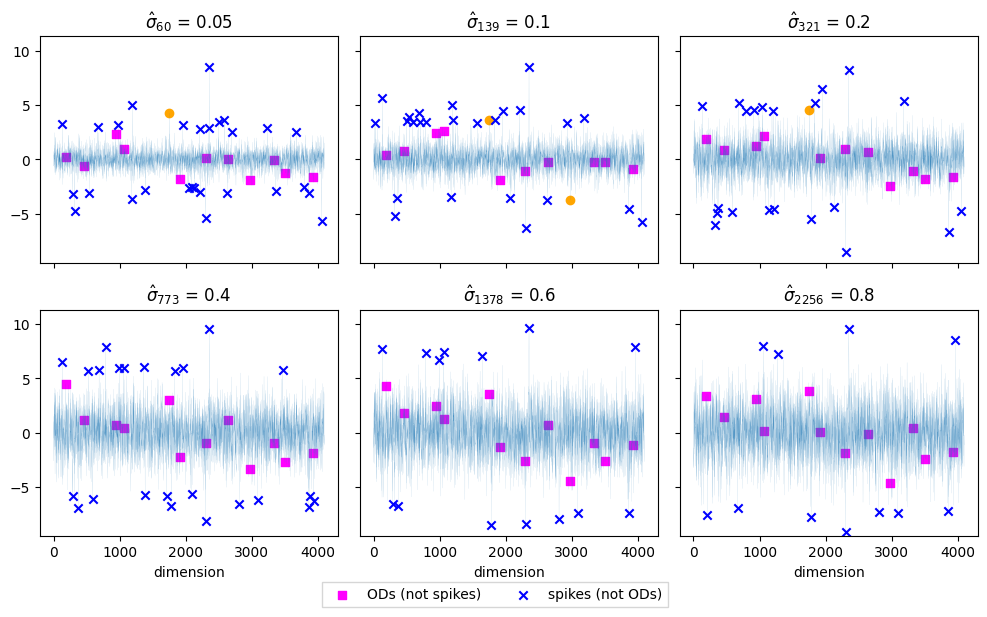

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Compute eigenvalues and eigenvectors
evals, evect = compute_eigen(w1, 'mlp_2')

# Define N values e.g., increasing by a power of 2
#N_values = [2, 3, 4, 5, 8, 16, 32, 128, 512]  # Up to 9 values

N_values=[0.05,0.1, 0.2, 0.4,0.6,0.8]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

# Get outlier dimensions (ODs)
ods = set(out_rep[str(last_layer)])

sorted_evals = np.sort(np.abs(evals))[::-1]  # Sort eigenvalues in descending order
cumulative_variance = np.cumsum(sorted_evals) / np.sum(sorted_evals)  # Compute CFV


f_spikes =[]
num_spikes, num_overlaps =[],[]  
    
for idx, N in enumerate(N_values):
    row, col = divmod(idx, 3)  # Get row and column index in 3x3 grid
    ax = axes[row, col]  # Select the subplot

    # Label x-axis only for the bottom row
    if row == len(axes) - 1:
        ax.set_xlabel("dimension")
        
    #top_indices = np.argsort(np.abs(evals))[::-1][:N]

    top_indices = np.arange(-1,-np.where(cumulative_variance <=N)[0][-1]-2,-1)#+1 but sorted neg.
    #print(top_indices)
    
    # Compute the linear combination
    v_combined = np.sum(evals[top_indices] * evect[:, top_indices], axis=1)
    
    # Find spikes
    f_spikes = find_spikes2(v_combined)
    
    # Plot in the corresponding subplot
    ax.plot(v_combined, linewidth=0.05) #color='blue' #label=f"linear combination, scaled by eigenvalue λ{N}"

    for spike in ods:
        value = v_combined[spike]
        if spike not in f_spikes:
            color, marker = ('fuchsia', 's')
            ax.scatter(spike, value, color=color, marker=marker, label="ODs (not spikes)")
    
    # Iterate over spikes and ODs and plot
    for spike in f_spikes:
        value = v_combined[spike]
        if spike in ods:
            color, marker, label = ('orange', 'o', "spike∩ ODs")
        else:
            color, marker, label = ('blue', 'x', "spikes (not ODs)")
        ax.scatter(spike, value, color=color, marker=marker, label=label)
    
    # Ensure the legend only displays unique labels
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
    #ax.legend(unique_labels.values(), unique_labels.keys(), loc= "upper left")
    
    eig_ids = [-1,-2, -3, -4,] #-5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15]
    #eig_ids = range(7,25)
        
    #f_spikes = find_spikes2(evect[:, top_indices])  # Detect spikes
    ods = set(out_rep[str(last_layer)])  # Set of outlier dimensions
    overlaps = [spike for spike in f_spikes if spike in ods]  # Count overlaps

    print(len(f_spikes), len(ods), len(overlaps))
    
    num_spikes.append(len(f_spikes))  # Total spikes count
    num_overlaps.append(len(overlaps))  # Overlap count

    print(Overlap_test(len(v_combined), num_overlaps[-1], num_spikes[-1], len(overlaps), 1000))
    
    ax.set_title(f"$\hat\sigma_{{{str(top_indices[-1]-1).strip('-')}}}$ = {N}") # -1 due to indexing! top_indices Top-{} Eigenvectors for 

    ymin, ymax = ax.get_ylim()

    # Compute the adjustment
    yrange = ymax - ymin
    new_ylim = (ymin - 0.03 * yrange, ymax + 0.02 * yrange)

    # Set the new y-limits
    ax.set_ylim(new_ylim)

fig.legend(unique_labels.values(), unique_labels.keys(), loc='center',
            bbox_to_anchor=(0.5, -0.0),fancybox=False, shadow=False, ncol=3)
# Final formatting
#plt.xlabel("dimension")
plt.tight_layout()
plt.savefig(final_path+'_MLP2_weights_lin_combi_CumVar_sigma3.svg', bbox_inches='tight')
plt.show()


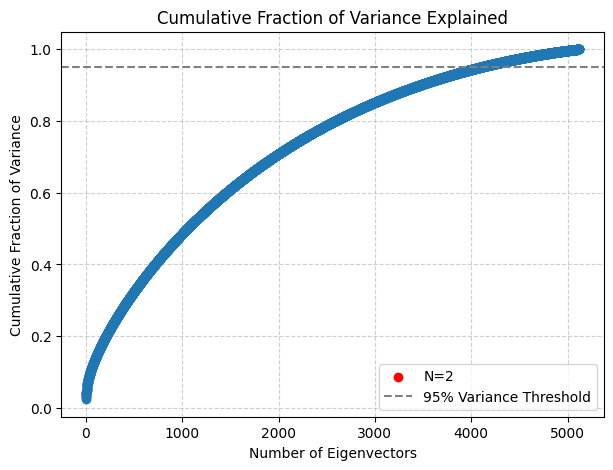

In [30]:
# Compute cumulative fraction of variance
sorted_evals = np.sort(np.abs(evals))[::-1]  # Sort eigenvalues in descending order
cumulative_variance = np.cumsum(sorted_evals) / np.sum(sorted_evals)  # Compute CFV

# Plot cumulative fraction of variance
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Mark specific N values
for N in N_values:
    if N < len(cumulative_variance):  # Ensure N is within bounds
        plt.scatter(N, cumulative_variance[N - 1], color='red', label=f"N={N}" if N == N_values[0] else "")

# Labels and title
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Cumulative Fraction of Variance")
plt.title("Cumulative Fraction of Variance Explained")
plt.axhline(y=0.95, color='gray', linestyle='--', label="95% Variance Threshold")  # Optional threshold line
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Save and show plot
plt.savefig(final_path+ '_MLP2_cumulative_variance.svg', bbox_inches='tight')
plt.show()

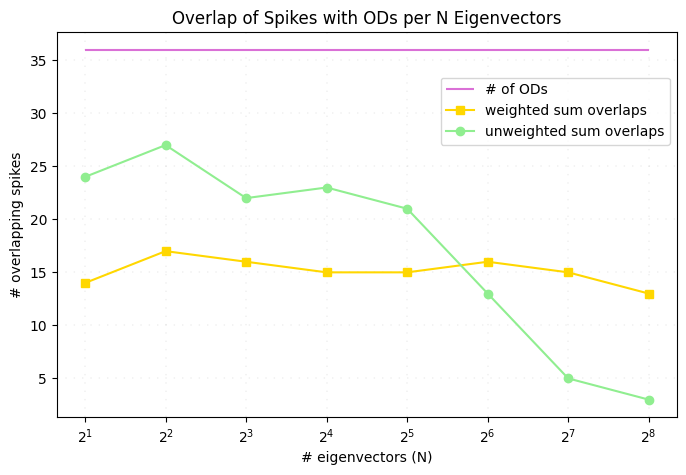

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Compute eigenvalues and eigenvectors
evals, evect = compute_eigen(w1, 'mlp_2')

# Define N values increasing by a power of 2
N_values = [2, 4, 8, 16, 32, 64, 128, 256]

# Get outlier dimensions (ODs)
ods = set(out_rep[str(last_layer)])

# Store results
overlap_weighted = []
overlap_unweighted = []

for N in N_values:
    # Sort and get the top-N eigenvectors
    top_indices = np.argsort(np.abs(evals))[::-1][:N]
    
    # Compute weighted sum (lambda_i * v_i)
    v_weighted = np.sum(evals[top_indices] * evect[:, top_indices], axis=1)
    
    # Compute unweighted sum (just summing eigenvectors)
    v_unweighted = np.sum(evect[:, top_indices], axis=1)
    
    # Find spikes
    spikes_weighted = find_spikes2(v_weighted)
    spikes_unweighted = find_spikes2(v_unweighted)
    
    # Count overlaps with ODs
    overlap_weighted.append(sum(spike in ods for spike in spikes_weighted))
    overlap_unweighted.append(sum(spike in ods for spike in spikes_unweighted))

# Plot the results
plt.figure(figsize=(8, 5))
plt.hlines(len(ods), N_values[0], N_values[-1], color="orchid", label='# of ODs')
plt.plot(N_values, overlap_weighted, color="gold", marker="s", label="weighted sum overlaps")
plt.plot(N_values, overlap_unweighted,  color="lightgreen", marker="o", label="unweighted sum overlaps")

plt.xscale('log', base=2)  # Log scale for N values
plt.xlabel("# eigenvectors (N)")
plt.ylabel("# overlapping spikes")
plt.title("Overlap of Spikes with ODs per N Eigenvectors")
plt.legend(loc ="best",bbox_to_anchor=(0.5, 0.4, 0.5, 0.5))
plt.grid(True, linestyle =(0, (5, 25)), linewidth = 0.2)
plt.savefig(final_path+'_MLP2_weights_lincombi_compare_sigma3.svg', bbox_inches='tight')
plt.show()
